# <font size="5">Classifying tree species from hyperspectral data using **Hyper3Dnet model**</font>

In [13]:
#Importing libraries 
import os
import h5py
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
import numpy as np
import scipy.io as sio
#conda install -c anaconda scikit-learn
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.decomposition import PCA
import tensorflow.keras.backend as k
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from argparse import ArgumentParser
import tensorflow as tf
import glob
#conda install pandas
import pandas as pd
from matplotlib import pyplot #conda install -c conda-forge matplotlib
import matplotlib.pyplot as plt
#The model : packages
from tensorflow.keras.layers import Conv3D, SeparableConv2D, Dense, Reshape, Flatten, Dropout, Conv2D
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model

import tensorflow.keras.backend as k
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model
from tensorflow import keras 
from tensorflow.keras.models import Model
import pickle
import time
import cv2  #conda install -c conda-forge opencv
import spectral  #conda install -c conda-forge spectral
from operator import truediv
import psutil #conda install -c conda-forge psutil

In [18]:
#Reading the .mat files (data and groud truth) and normalizing the data
def read( img, gt):
    '''
        img : the data directory 
        gt  : the groud truth data directory 
        
        return 
        data  : numpy.ndarray for data
        label : numpy.ndarray for the label
    '''
    liste = ['__globals__', '__header__', '__version__']
    data = sio.loadmat(img)
    k= data.keys()
      #Getting stored data by comparing the file layers to the default .mat layer
    list_difference = [item for item in k if item not in liste]
    data = data[list_difference[0]]
    #normalization
    data= np.nan_to_num(data)
    data_min = data.min(axis=(0, 1), keepdims=True)
    data_max = data.max(axis=(0, 1), keepdims=True)
    data=(data - data_min)/(data_max - data_min)
    data= np.swapaxes(data, 0, 1)  #swaping axes for data 
    # reading the ground truth data 
    label = sio.loadmat(gt)
    k= label.keys()
    list_difference = [item for item in k if item not in liste]
    label = label[list_difference[0]]
    return data, label

def GT_data_frame(gt_1) :
    '''
    Show the distribution of the ground truth data
        gt_1 : the ground truth numpy.ndarray
        
    returns  : class_distribution_source : distribution of the data
    '''
    class_distribution_source = pd.DataFrame(np.unique(gt_1, return_counts = True)) #converted to dataframe and count
    class_distribution_source = class_distribution_source.transpose()
    class_distribution_source.columns = ['class','pix_samples'] #Shows the distribution
    return class_distribution_source


def plot_df(df): 
    '''
    Plot the ground truth dataframe distribution as a bar cart and save it
    '''
    x = df.index
    y = df.pix_samples
    plt.xlabel("Classes")
    plt.ylabel("Nombre de jeu de données")
    #plt.title("Nombre de classes représentées dans le jeu de données", df)
    plt.bar(x, y)
    print( "Distribution de la réalité terrain sous format graphique : \n  ")
    plt.savefig('Ditribution_réalité terrain.png')

def analy_df(df): 
    '''
        Extract major labels codes 
        input :    df : the dataframe of the ground truth data
        
        output :   code: the first major labels of the data
    '''
    print("Ce jeu de données contient : ", len(df),"espèces")
    df = df.reset_index() 
    data=df.sort_values('pix_samples', ascending=False)  #Sorting
      ##Extraction des labels/ classes à garder : extraction des 10 premières valeurs du pd
      # iloc[row slicing, column slicing]
    test=data.iloc[0:11, 0:1]  #Extraction des classes majoritaires + backgrounnd
    code= test.values.flatten()
    print("Les codes des classes majoritaires et le fond est : ", code, "leur nombre est : ", len(code))
      #Le type de chaque code dans la liste est class 'numpy.int64'>
    return code

In [19]:
#Réduction de dimensionalité
def applyPCA(Xc, numComponents=10):
    '''
    Xc : data ( Image PRISMA as numpy.ndarray)
    numComponents : the number of keeped components from PCA
    '''
    newX = np.reshape(Xc, (-1, Xc.shape[2]))
    pcaC = PCA(n_components=numComponents, whiten=True)  
    newX = pcaC.fit_transform(newX) 
    newX = np.reshape(newX, (Xc.shape[0], Xc.shape[1], numComponents))
    return newX, pcaC

##Découpage des images et génération des patchs
def padWithZeros(Xc, margin=2):
    '''
        Creating zero pads for patchs creating with a margin of 2
    '''
    newX = np.zeros((Xc.shape[0] + 2 * margin, Xc.shape[1] + 2 * margin, Xc.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:Xc.shape[0] + x_offset, y_offset:Xc.shape[1] + y_offset, :] = Xc
    return newX
#Removing 0 labels !
def createImageCubes(Xc, yc, window=1, removeZeroLabels=True):
    '''
        Create patchs/cube of size (,window,window, Xc[2]) without labels with 0
        
    '''
    margin = int((window - 1) / 2)
    zeroPaddedX = padWithZeros(Xc, margin=margin)
    # split patches
    patchesData = np.zeros((Xc.shape[0] * Xc.shape[1], window, window, Xc.shape[2]))
    patchesLabels = np.zeros((Xc.shape[0] * Xc.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = yc[r - margin, c - margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        print("labels are : ", patchesLabels)
        patchesLabels -= 1
        print("Number of labels without the background labels is : ", len(patchesLabels))
    return patchesData, patchesLabels

Entrez le chemin de l'image à classifier (ex : /projects/data/):  /projects/data/
Entrez le chemin de la réalité terrain  (ex: /projects/data/):  /projects/data/


Le chemin des données de réalité terrain :  ['/projects/data/france_region2_GT.mat', '/projects/data/france_region2_data.mat']
Le chemin de l'image :  ['/projects/data/france_region2_GT.mat', '/projects/data/france_region2_data.mat']
Distribution de la réalité terrain : 
       class  pix_samples
0       0       992594
1       1         6430
2       2        14151
3       3        21073
4       4        46659
5       5       253609
6       6         5987
7       7        53053
8       8         1797
9       9         6741
10     10        44433
11     11           52
12     13           96
13     15         2326
14     18        16295
Distribution de la réalité terrain sous format graphique : 
  


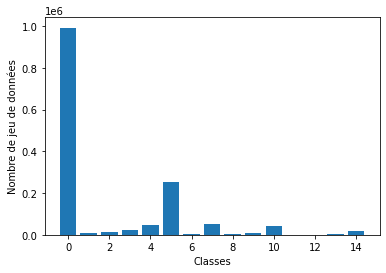

In [20]:
dir_img = str(input("Entrez le chemin de l'image à classifier (ex : /projects/data/): ")) #Nom du dossier de l'image
dir_gt =str(input("Entrez le chemin de la réalité terrain  (ex: /projects/data/): "))     #Nom du dossier de la gt
img = sorted(glob.glob(dir_img +'/'+ '*.mat'))
gt = sorted(glob.glob(dir_gt + '/'+'*.mat'))
print("Le chemin des données de réalité terrain : " , gt)
print("Le chemin de l'image : ",img)
data_1, label_1 = read(img[1],gt[0])
#Compte des labels et leurs correspondants
label_1_df = GT_data_frame(label_1)  #distribution des labels de l'im 
print("Distribution de la réalité terrain : \n  ",  label_1_df)
#Affichage de la distribution : saved as png 
plot_df(label_1_df)

In [21]:
print(data_1.shape)
print(label_1.shape)
    #Creating a directory to save the training weights while training
working_dir = os.getcwd()
print(working_dir)
path = os.path.join(working_dir+'/',"weights")
if os.path.exists(path):
    print(path + ' : exists')
    if os.path.isdir(path):
        print(path + ' : is a directory')
if not os.path.exists(path):
    os.mkdir(path)

(1246, 1176, 231)
(1246, 1176)
/projects
/projects/weights : exists
/projects/weights : is a directory


In [22]:
#Récupération des classes majoritaires et app du masque pour les classes minoritaires
especes_1= analy_df(label_1_df)  #Je garde les 9 espèces majoritaires y compris le background
mask_1= np.isin(label_1, especes_1, invert=False) #True ==> les valeurs à remplacer par 0
y_1=1*mask_1  
label_1= label_1*y_1  #Labels avec les classes majoritaires uniquement

    #Nouvelle distribution du jeu de données terrain
lab=GT_data_frame(label_1)

    #Reclassification des espèces d'arbres

label_shape=label_1.shape
##Reclassification de ces labels
espece_maj = especes_1.tolist() #Conversion to list
espece_maj.sort()  #Sorting de ces codes  : je les classe par ordre croissant 
print("Les codes des espèces majoritaires dans mon jeu de données :", espece_maj)
#Créer la liste des nouvelles classes : 
inter_labels= list(range(max(espece_maj)+1, max(espece_maj)+len( espece_maj)+1))
final_labels = [i for i in range(len(especes_1))]
print("Les nouveaux codes attribués sont :", final_labels)

#Remplacer chaque éléments du [ 0 14 10  5  7  2  9  3 12]  dans le tableau ( label_f) par [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#Première itération : [0, 2, 3, 5, 7, 9, 10, 12, 14] ==> [15, 16, 17, 18, 19, 20, 21, 22, 23]
for i in range(label_shape[0]) :
  for j in range(label_shape[1]):
    for k in range(len(espece_maj)): 
      if label_1[i][j]== espece_maj[k]:
        label_1[i][j] = inter_labels[k]
#Seconde itération : [15, 16, 17, 18, 19, 20, 21, 22, 23] ==> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in range(label_shape[0]) :
  for j in range(label_shape[1]):
    for k in range(len(espece_maj)): 
      if label_1[i][j]== inter_labels[k]:
        label_1[i][j] = final_labels[k]   #Création du jeu de données final

## La distribution des classes d'arbres reclassifiées 

label_1_df = GT_data_frame(label_1)  #distribution des labels de l'im 
print("Distribution de la réalité terrain avec les classes majoritaires reclassifiés : : \n  ",  label_1_df)


Ce jeu de données contient :  15 espèces
Les codes des classes majoritaires et le fond est :  [ 0  5  7  4 10  3 14  2  9  1  6] leur nombre est :  11
Les codes des espèces majoritaires dans mon jeu de données : [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 14]
Les nouveaux codes attribués sont : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Distribution de la réalité terrain avec les classes majoritaires reclassifiés : : 
      class  pix_samples
0      0      1013160
1      1         6430
2      2        14151
3      3        21073
4      4        46659
5      5       253609
6      6         5987
7      7        53053
8      8         6741
9      9        44433


In [23]:
#Application de la PCA
x_1, pca_1 = applyPCA(data_1, numComponents=30)

### GPU uses checking

In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7503106910150531819
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14812515864759804869
physical_device_desc: "device: XLA_CPU device"
]


In [13]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [16]:
import os
os.cpu_count()

8

In [20]:
import psutil
from psutil import virtual_memory  #conda install -c conda-forge psutil
mem =virtual_memory()
print("Mémoire totale en GB :", mem.total >> 30)
print("Mémoire disponible en GB : ", mem.available>> 30)

Mémoire totale en GB : 62
Mémoire disponible en GB :  57


### back to data processing

In [24]:
##Extraction de patchs
x_data_1, y_label_1 = createImageCubes(x_1, label_1, window=5)
print( "x_data shape : ", x_data_1.shape)
print( "y_data shape : ", y_label_1.shape)

(unique, counts) = np.unique(y_label_1, return_counts=True)
print("Les codes label de la réalité terrain sont : ", unique)

classes = int(np.max(y_label_1)) + 1
print("Le nombre de classes à entrainées : ", classes)
#(unique, counts) = np.unique(y_data, return_counts=True)
(unique, counts) = np.unique(y_label_1, return_counts=True)
print("Le nombre de classes à entrainées : ", len(unique))

#Définition de la taille des imagettes 
windowSize = x_data_1.shape[1]

labels are :  [2. 2. 2. ... 5. 5. 5.]
Number of labels without the background labels is :  452136
x_data shape :  (452136, 5, 5, 30)
y_data shape :  (452136,)
Les codes label de la réalité terrain sont :  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
Le nombre de classes à entrainées :  9
Le nombre de classes à entrainées :  9


# <font size="5">  **Hyper3Dnet model** definition and classification </font>



y_label_1 = np.load('/projects/data/region2/label_fr_test_region2.npy')
x_data_1 = np.load('/projects/data/region2/data_fr_test_region2.npy')

print(x_data_1.shape)
print(y_label_1.shape)

In [25]:
from sklearn.model_selection import StratifiedKFold
classes = int(np.max(y_label_1)) + 1   #Number of classes used in classification
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
#Metrics initialization
cvoa = []
cvaa = []
cvka = []
cvpre = []
cvrec = []
cvf1 = []
network = 'hyper3dnet'

# Confusion matrix initialization 
confmatrices = np.zeros((10, int(classes), int(classes)))
ntrain = 1
model = None

import tensorflow.keras.backend as k
k.set_image_data_format('channels_last')
k.set_learning_phase(1)

def conv3d_attention(inp, filters, kernel_size=(3, 3, 7), padding='same', strides=(1, 1, 1)):
    conv = Conv3D(filters=filters, kernel_size=kernel_size, padding=padding, strides=strides)(inp)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv

#The model definition

def hyper3dnet(img_shape=(256, 256, 50, 1), classes=2):
    # Input
    d0 = Input(shape=img_shape)

    # 3D convolutions
    conv_layer1 = conv3d_attention(d0, 8)
    conv_layer2 = conv3d_attention(conv_layer1, 8)
    conv_in = Concatenate()([conv_layer1, conv_layer2])
    conv_layer3 = conv3d_attention(conv_in, 8)
    conv_in = Concatenate()([conv_in, conv_layer3])
    conv_layer4 = conv3d_attention(conv_in, 8)
    conv_in = Concatenate()([conv_in, conv_layer4])

    #conv_in = Reshape((conv_in.shape[1].value, conv_in.shape[2].value,
                       #conv_in.shape[3].value * conv_in.shape[4].value))(conv_in)
    
    conv_in = Reshape((conv_in.shape[1], conv_in.shape[2],
                       conv_in.shape[3] * conv_in.shape[4]))(conv_in)

    conv_in = SeparableConv2D(128, kernel_size=3, strides=(1, 1), padding='same',
                              dilation_rate=1)(conv_in)
    conv_in = BatchNormalization()(conv_in)
    conv_in = Activation('relu')(conv_in)
    conv_in = SeparableConv2D(128, kernel_size=3, strides=(2, 2), padding='same',
                              dilation_rate=1)(conv_in)
    conv_in = BatchNormalization()(conv_in)
    conv_in = Activation('relu')(conv_in)
    conv_in = SeparableConv2D(128, kernel_size=3, strides=(2, 2), padding='same',
                              dilation_rate=1)(conv_in)
    conv_in = BatchNormalization()(conv_in)
    conv_in = Activation('relu')(conv_in)
    conv_in = SeparableConv2D(128, kernel_size=3, strides=(2, 2), padding='same',
                              dilation_rate=1)(conv_in)
    conv_in = BatchNormalization()(conv_in)
    conv_in = Activation('relu')(conv_in)

    conv_in = Flatten()(conv_in)
    conv_in = Dropout(0.5)(conv_in)

    if classes == 2:
        fc1 = Dense(1, name='fc' + str(1), activation='sigmoid')(conv_in) #Classification binaire
    else:
        fc1 = Dense(classes, name='fc' + str(classes), activation='softmax')(conv_in)
        #fc1 = Dense(6, name='fc' + str(classes), activation='softmax')(conv_in)

    return Model(d0, fc1)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [26]:
#Metrics calculation based on the confusion matrix
def AA_andEachClassAccuracy(confusion_m):
    list_diag = np.diag(confusion_m)
    list_raw_sum = np.sum(confusion_m, axis=1)
    each_ac = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_ac)
    return each_ac, average_acc  

In [ ]:
dataset=img[0].split("/")[-1]
dataset=dataset.split(".")[0]
choice = str(input("Entrez ( train) si c'est le premier entrainement du modèle ou (continue) si vous voulez poursuivre un entrainement :  "))
if choice == "train" : 
  start = time.process_time()
  for train, test in kfold.split(x_data_1, y_label_1):
    
      ytrain = to_categorical(y_label_1[train]).astype(np.int32)
      ytest = to_categorical(y_label_1[test]).astype(np.int32)
    
      # Compile model
      model = hyper3dnet(img_shape=(windowSize, windowSize, x_data_1.shape[3], 1), classes=classes)
      model.summary()
      optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
      model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
      model.trainable = True

      # checkpoint : saving best weight model
      filepath = path +"/" + dataset  + "/HYPER3DNET" + network + dataset + str(ntrain) + ".h5"
      checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
      #saveèbest_only : your saved model will be replaced after every epoch.
      callbacks_list = [checkpoint]

      #saving weights
      model.save_weights(path + "/" + dataset + 'weights.h5')

      #ep = 70 #50
      ep = int(input("Entrez le nombre d'époques d'entrainement : "))
      # Train model on dataset
      print(dataset + ": Training" + str(ntrain) + "begins...")
      history = model.fit(x=x_data_1[train], y=ytrain, validation_data=(x_data_1[test], ytest),
                          batch_size=4, epochs=ep, callbacks=callbacks_list)
    
      # saving the file:
      f = open('history_training'+dataset+ ".pckl", 'wb')
      pickle.dump(history.history, f)
      f.close()
      print("Le temps d'entrainement est : ", time.process_time() - start)
    
      #Affichage des performances d'entrainement
      pyplot.plot(history.history['acc'], label='train')
      pyplot.plot(history.history['val_acc'], label='test')
      pyplot.legend()
      pyplot.show()
      # Evaluate network

       # evaluate on test set

      # load checkpointed(best) model for evaluation on test set
      model_for_evaluation = load_model(path +"/" + dataset  + "/HYPER3DNET" + network + dataset + str(ntrain) + ".h5")
      evaluation = model_for_evaluation.evaluate(x_data_1[test], ytest) 
      print("Test Accuracy (while training) = ", np.round(evaluation[1] * 100))

      #Building predictions and evaluation 
      model.trainable = False
      model.load_weights(filepath)
      ypred = model.predict(x_data_1[test])   #Les prédictions du modèle

      # Calculate metrics
      oa = accuracy_score(np.argmax(ytest, axis=1), np.argmax(ypred, axis=-1))
      confusion = confusion_matrix(np.argmax(ytest, axis=1), np.argmax(ypred, axis=-1))
      print("La matrice de confusion à partir des données prédites : \n", confusion)
      each_acc, aa = AA_andEachClassAccuracy(confusion)
      print("Les précisions indivisuelles des classes sont : ", each_acc)
      kappa = cohen_kappa_score(np.argmax(ytest, axis=1), np.argmax(ypred, axis=-1))
      prec, rec, f1, support = precision_recall_fscore_support(np.argmax(ytest, axis=1),
                                                              np.argmax(ypred, axis=-1), average='macro')
      #Matrice de confusion à partir des prédictions
      # Add metrics to the list
      cvoa.append(oa * 100)
      cvaa.append(aa * 100)
      cvka.append(kappa * 100)
      cvpre.append(prec * 100)
      cvrec.append(rec * 100)
      cvf1.append(f1 * 100)
      file_name = "classification_report_" + dataset + ".txt"
      with open(file_name, 'w') as x_file:
        x_file.write("Overall accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvoa)), float(np.std(cvoa))))
        x_file.write('\n')
        x_file.write("Average accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvaa)), float(np.std(cvaa))))
        x_file.write('\n')
        x_file.write("Kappa accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvka)), float(np.std(cvka))))
        x_file.write('\n')
        x_file.write("Precision accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvpre)), float(np.std(cvpre))))
        x_file.write('\n')
        x_file.write("Recall accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvrec)), float(np.std(cvrec))))
        x_file.write('\n')
        x_file.write("F1 accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvf1)), float(np.std(cvf1))))

      ntrain += 1
elif choice == "continue" : 
  filepath = str(input("Entrez le chemin du fichier d'entrainement "))
  model =  load_model(filepath)
  # get weights
  modelWeights = model.get_weights()
 # get optimizer state as it was on last epoch
  modelOptimizer = model.optimizer
 # ============ Compile Model ============
 # redefine architecture (newModel=models.Sequential(), etc.)
  newModel= hyper3dnet(img_shape=(windowSize, windowSize, x_data_1.shape[3], 1), classes=classes)
  optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)  
  # compile
  newModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

  start = time.process_time()
  for train, test in kfold.split(x_data_1, y_label_1):
    
      ytrain = to_categorical(y_label_1[train]).astype(np.int32)
      ytest = to_categorical(y_label_1[test]).astype(np.int32)
      # Compile model
      newModel= hyper3dnet(img_shape=(windowSize, windowSize, x_data_1.shape[3], 1), classes=classes)
      #model.summary()
      optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
      newModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
      newModel.set_weights(modelWeights)
      #model.trainable = True
      # checkpoint : saving the best new weight model
      filepath = "weights/" + dataset + "/" + network + "/continue" + dataset + str(ntrain) + ".h5"
      checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
      #saveèbest_only : your saved model will be replaced after every epoch.
      callbacks_list = [checkpoint]

      #saving weights
      model.save_weights(path +"/" + dataset + 'continued_weights.h5')

      ep = int(input("Entrez le nombre d'époques d'entrainement : "))
      # Train model on dataset
      print(dataset + ": Training" + str(ntrain) + "begins...")
      history = newModel.fit(x=x_data_1[train], y=ytrain, validation_data=(x_data_1[test], ytest),
                          batch_size=4, epochs=ep, callbacks=callbacks_list)
    
      # saving the file:
      f = open('history_training'+dataset+ ".pckl", 'wb')
      pickle.dump(history.history, f)
      f.close()
      print("Le temps d'entrainement est : ", time.process_time() - start)
    
      #Affichage des performances d'entrainement
      pyplot.plot(history.history['acc'], label='train')
      pyplot.plot(history.history['val_acc'], label='test')
      pyplot.legend()
      pyplot.show()
     # Evaluate network
    # evaluate on test set
    # load checkpointed(best) model for evaluation on test set
      model_for_evaluation = load_model(path+ "/" + network + "/continue" + dataset + str(ntrain) + ".h5")
      evaluation = model_for_evaluation.evaluate(x_data_1[test], ytest) 
      print("Test Accuracy = ", np.round(evaluation[1] * 100))

      #Building predictions and evaluation 
      model.trainable = False
      model.load_weights(filepath)
      ypred = model.predict(x_data_1[test])   #Les prédictions du modèle

      # Calculate metrics
      oa = accuracy_score(np.argmax(ytest, axis=1), np.argmax(ypred, axis=-1))
      confusion = confusion_matrix(np.argmax(ytest, axis=1), np.argmax(ypred, axis=-1))
      print("La matrice de confusion à partir des données prédites : \n", confusion)
      each_acc, aa = AA_andEachClassAccuracy(confusion)
      print("Les précisions indivisuelles des classes après pousuite de l'entrainement sont : ", each_acc)
      kappa = cohen_kappa_score(np.argmax(ytest, axis=1), np.argmax(ypred, axis=-1))
      prec, rec, f1, support = precision_recall_fscore_support(np.argmax(ytest, axis=1),
                                                              np.argmax(ypred, axis=-1), average='macro')
      #Matrice de confusion à partir des prédictions
      # Add metrics to the list
      cvoa.append(oa * 100)
      cvaa.append(aa * 100)
      cvka.append(kappa * 100)
      cvpre.append(prec * 100)
      cvrec.append(rec * 100)
      cvf1.append(f1 * 100)
      file_name = "classification_report_" + dataset + ".txt"
      with open(file_name, 'w') as x_file:
        x_file.write("pursuing the classification : ")
        x_file.write("Overall accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvoa)), float(np.std(cvoa))))
        x_file.write('\n')
        x_file.write("Average accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvaa)), float(np.std(cvaa))))
        x_file.write('\n')
        x_file.write("Kappa accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvka)), float(np.std(cvka))))
        x_file.write('\n')
        x_file.write("Precision accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvpre)), float(np.std(cvpre))))
        x_file.write('\n')
        x_file.write("Recall accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvrec)), float(np.std(cvrec))))
        x_file.write('\n')
        x_file.write("F1 accuracy%.3f%% (+/- %.3f%%)" % (float(np.mean(cvf1)), float(np.std(cvf1))))

      ntrain += 1
else : 
  print("Votre saisie est incorrecte ")

Entrez ( train) si c'est le premier entrainement du modèle ou (continue) si vous voulez poursuivre un entrainement :   train


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 5, 30, 1) 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 5, 5, 30, 8)  512         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5, 5, 30, 8)  32          conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 5, 5, 30, 8)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

Entrez le nombre d'époques d'entrainement :  50


france_region2_GT: Training1begins...
Epoch 1/50
 39492/101731 [==========>...................] - ETA: 35:51 - loss: 1.3335 - acc: 0.5895

<font size="3"> <span style="color:blue"> *warning* </span>

<font size="2">incase this message appears </font> : 
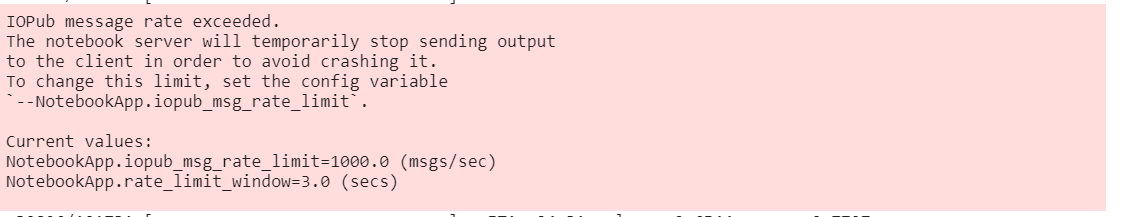 </span>

    Type in your terminal : jupyter notebook --generate-config 
    find the path of the file jupyter_notebook_config.py  ( ex . ls -ls projects/.jupyter/jupyter_notebook_config.py ) 
    Open the file by "vim" command : (ex. vim /projects/.jupyter/jupyter_notebook_config.py) 
    type i for instert and rise up the  c.NotebookApp.iopub_data_rate_limit value 
    esc then :mq for saving changes and quit